<a href="https://colab.research.google.com/github/xorgoat/Chitter_ML/blob/un-resized-spectrograms-patch-1/birdspectrogrammodelpatch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Define the folder where you saved the data in
path = "C:\\Users\\arice\\OneDrive\\Documents\\Chitter_ML data\\bird_spectrograms\\"

#from google.colab import drive
#drive.mount('/gdrive')
#!ln -s "/gdrive/My Drive/Chitter_ML Data" "/content/Chitter_ML Data"

#path = "/content/Chitter_ML Data/_final_bird_audio/spectrograms"

In [2]:
#basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

#for images
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from skimage.transform import resize

#Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


#Model selection
from sklearn.model_selection import GridSearchCV

#evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

### SDV (Singular Value Decomposition - compressing images)

In [3]:
#have to do this before x y assignment
#tried variance threshold too, but will not be using as it is a hassle for our type of data

#trying to compress color channels with SVD here
#also see https://stackabuse.com/dimensionality-reduction-in-python-with-scikit-learn/
from PIL import Image

#get colors
def color_isolation(img_file):
  img = Image.open(img_file)
  #display(img)
  im_array = np.array(img)
  red = im_array[:, :, 0]
  green = im_array[:, :, 1]
  blue = im_array[:, :, 2]
  return red, green, blue

#compress color channels
def compress_channel(color_channel, n):
  u, s, v = np.linalg.svd(color_channel)
  compressed = np.zeros((color_channel.shape[0], color_channel.shape[1]))

  left_matrix = np.matmul(u[:, 0:n], np.diag(s)[0:n, 0:n])
  inner_compressed = np.matmul(left_matrix, v[0:n, :])
  compressed = inner_compressed.astype('uint8')

  return compressed

#put compressed color channels into image
def compress_image(red, green, blue, n):
  compressed_red = compress_channel(red, n)
  compressed_green = compress_channel(green, n)
  compressed_blue = compress_channel(blue, n)

  im_red = Image.fromarray(compressed_red)
  im_blue = Image.fromarray(compressed_blue)
  im_green = Image.fromarray(compressed_green)

  new_image = Image.merge("RGB", (im_red, im_green, im_blue))
  #new_image.show()

  return new_image

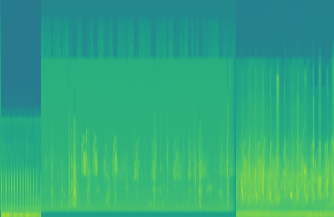

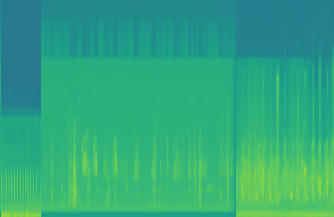

In [4]:
#example for finding the right n
path_img = os.path.join(path, "test\\Baillon_s Crake\\xc34132.png")#"/content/Chitter_ML Data/_final_bird_audio/spectrograms/test/Baillon's Crake/xc34132.png"

red, green, blue = color_isolation(path_img) 
img = Image.open(path_img)
display(img)
n = 20
new_image = compress_image(red, green, blue, n)
display(new_image) #do NOT use img.show() https://stackoverflow.com/questions/60034512/cant-show-an-image-using-pil-on-google-colab


### X_train

(237, 217, 334, 4)
(237,)

Example:
Baillon_s Crake


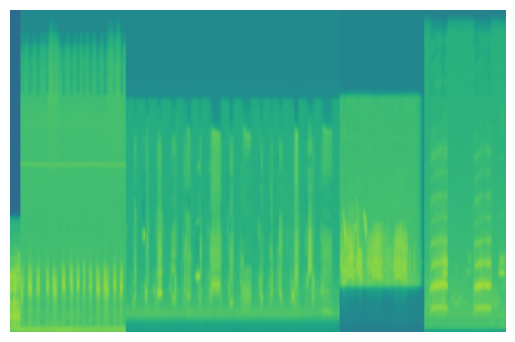

In [5]:
#going through train images and calling functions
train_path = os.path.join(path,"train")
new_directory = "/content/Chitter_ML Data/_final_bird_audio/spectrograms_compressed/train" #change if your path is different
plt.axis('off')

#Defining X_train y_train
X_train = []  #creating a list for the images
y_train = []  #creating the labels

#go through every bird in every species
for species in os.listdir(train_path):
    folder_path = os.path.join(train_path, species) 
    try:
      new_folder = os.path.join(new_directory, species)
      os.makedirs(new_folder)
    except: #if directory already exists, just continue
      pass
    for bird_image in os.listdir(folder_path):
      image_path = os.path.join(folder_path, bird_image)
      img = mpimg.imread(image_path) #turning image into array
      X_train.append(img)
      y_train.append(species)

      #SDV
      new_path = os.path.join(new_folder, bird_image)
      red, green, blue = color_isolation(image_path) 
      n = 5 #limit of image compression (closer to 0 is higher degree), needs to be lower than lowest dimension of pixels (217)
      new_image = compress_image(red, green, blue, n)
      new_image.save(new_path)

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

print(X_train_np.shape) #output dimensions (number of images,pixels_x,pixels_y,rgb)
print(y_train_np.shape) #output dimensions (number of images,)

print("\nExample:")
img_train = X_train_np[0]
plt.imshow(img_train)
print(y_train_np[0])

### X_test

(52, 217, 334, 4)
(52,)

Example:
Baillon_s Crake


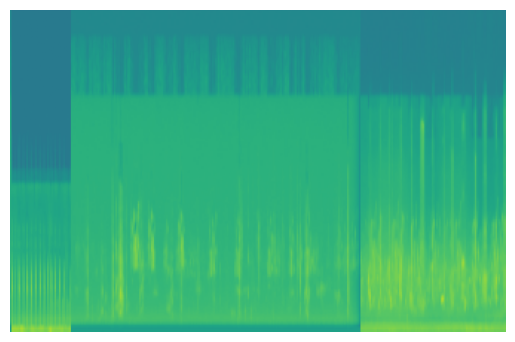

In [6]:
#going through test images and calling functions
test_path = os.path.join(path,"test")
new_directory = "/content/Chitter_ML Data/_final_bird_audio/spectrograms_compressed/test" #change if your path is different
plt.axis('off')

#Defining X_test y_test
X_test = []  #creating a list for the images
y_test = []  #creating the labels

#go through every bird in every species
for species in os.listdir(test_path):
    folder_path = os.path.join(test_path, species) 
    try:
      new_folder = os.path.join(new_directory, species)
      os.makedirs(new_folder)
    except: #if directory already exists, just continue
      pass
    for bird_image in os.listdir(folder_path):
      image_path = os.path.join(folder_path, bird_image)
      img = mpimg.imread(image_path) #turning image into array
      X_test.append(img)
      y_test.append(species)

      #SDV
      new_path = os.path.join(new_folder, bird_image)
      red, green, blue = color_isolation(image_path) 
      n = 5 #limit of image compression (closer to 0 is higher degree), needs to be lower than lowest dimension of pixels (217)
      new_image = compress_image(red, green, blue, n)
      new_image.save(new_path)

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

print(X_test_np.shape) #output dimensions (number of images,pixels_x,pixels_y,rgb)
print(y_test_np.shape) #output dimensions (number of images,)

print("\nExample:")
img_test = X_test_np[0]
plt.imshow(img_test)
print(y_test_np[0])

### X_valid

(60, 217, 334, 4)
(60,)

Example:
Baillon_s Crake


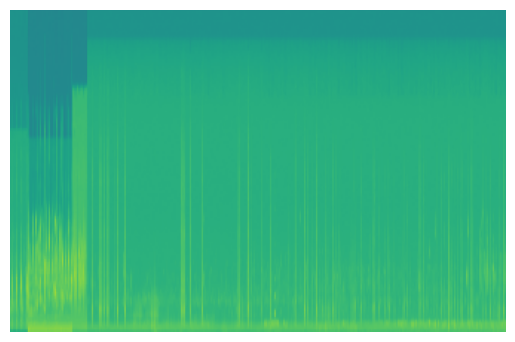

In [7]:
#going through validation images and calling functions
valid_path = os.path.join(path,"validation")
new_directory = "/content/Chitter_ML Data/_final_bird_audio/spectrograms_compressed/validation" #change if your path is different
plt.axis('off')

#Defining X_valid y_valid
X_valid = []  #creating a list for the images
y_valid = []  #creating the labels

#go through every bird in every species
for species in os.listdir(valid_path):
    folder_path = os.path.join(valid_path, species) 
    try:
      new_folder = os.path.join(new_directory, species)
      os.makedirs(new_folder)
    except: #if directory already exists, just continue
      pass
    for bird_image in os.listdir(folder_path):
      image_path = os.path.join(folder_path, bird_image)
      img = mpimg.imread(image_path) #turning image into array
      X_valid.append(img)
      y_valid.append(species)

      #SDV
      new_path = os.path.join(new_folder, bird_image)
      red, green, blue = color_isolation(image_path) 
      n = 5 #limit of image compression (closer to 0 is higher degree), needs to be lower than lowest dimension of pixels (217)
      new_image = compress_image(red, green, blue, n)
      new_image.save(new_path)

X_valid_np = np.array(X_valid)
y_valid_np = np.array(y_valid)

print(X_valid_np.shape) #output dimensions (number of images,pixels_x,pixels_y,rgb)
print(y_valid_np.shape) #output dimensions (number of images,)

print("\nExample:")
img_valid = X_valid_np[0]
plt.imshow(img_valid)
print(y_valid_np[0])

### PCA

In [8]:
#flattening the arrays for pca, but this is WRONG
#needs to be done for every color channel
#tutorial (scroll past the digits) https://www.askpython.com/python/examples/principal-component-analysis-for-image-data

X_train_rs = X_train_np.reshape(237, 217* 334* 4)
X_valid_rs = X_valid_np.reshape(60, 217* 334* 4)
X_test_rs = X_test_np.reshape(52, 217* 334* 4)



In [9]:
#Implementing PCA
n_components = 45    ###probably needs to be 500+
pca = PCA(n_components=n_components)
pca1 = pca.fit(X_train_rs)
X_train_pca = pca1.transform(X_train_rs)
X_valid_pca = pca1.transform(X_valid_rs)
X_test_pca = pca1.transform(X_test_rs)

# Percentage of variance explained for the sum of each component
print('explained variance ratio with n_components =', n_components ,': %s' % str(sum(pca.explained_variance_ratio_)))

#print(X_train_C.shape,X_pca_train.shape)

explained variance ratio with n_components = 45 : 0.9481950426707044


### Decision Tree

In [10]:
#setting the parameters for the decision tree 
param_grid_tree = {'max_depth':[2,5,8,12,16]}
#print("Parameter grid:\n{}".format(param_grid_tree))

grid_search_tree = GridSearchCV(DecisionTreeClassifier(), param_grid_tree, cv=5)
#fitting the model with the pca data
grid_search_tree.fit(X_train_pca, y_train_np)

#printing thebest parameters and score
print("Best parameter: {}, Best cross-validation score: {:.4f}\n".format(grid_search_tree.best_params_,grid_search_tree.best_score_))

c:\Users\arice\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameter: {'max_depth': 16}, Best cross-validation score: 0.5144



In [11]:
dtc = DecisionTreeClassifier(max_depth = 12).fit(X_train_pca, y_train_np)
y_pred_dtc = dtc.predict(X_test_pca)

In [12]:
#evaluation metrics
print("Accuracy: {:.3f}".format(accuracy_score(y_test_np, y_pred_dtc)))
#print("Confusion matrix:\n{}".format(confusion_matrix(y_test_np, y_pred_dtc)))
print("Weighted f1-score:", f1_score(y_test_np, y_pred_dtc, average='weighted'))

y_pred_dtc_train = dtc.predict(X_train_pca)
print("Weighted training f1-score:", f1_score(y_train_np, y_pred_dtc_train, average='weighted'))

Accuracy: 0.019
Weighted f1-score: 0.005494505494505494
Weighted training f1-score: 0.8755101582289254


In [13]:
### Logistic Regression

In [14]:
#Logistic regression grid search

#setting logreg parameters for grid search
param_grid_logreg = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

#creating the logreg model with 100000 max iterations and 5 fold cross validation
gs_logreg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logreg, cv=5)
gs_logreg.fit(X_train_pca, y_train_np)

print("Best parameter: {}, Best cross-validation score: {:.4f}\n".format(gs_logreg.best_params_,gs_logreg.best_score_))

c:\Users\arice\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\arice\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\arice\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number 

Best parameter: {'C': 0.1}, Best cross-validation score: 0.7594



In [15]:
#Logistic regression grid search

#setting logreg parameters for grid search
param_grid_logreg = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

#creating the logreg model with 100000 max iterations and 5 fold cross validation
gs_logreg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logreg, cv=5)
gs_logreg.fit(X_train_pca, y_train_np)

print("Best parameter: {}, Best cross-validation score: {:.4f}\n".format(gs_logreg.best_params_,gs_logreg.best_score_))

c:\Users\arice\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\arice\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\arice\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number 

Best parameter: {'C': 0.1}, Best cross-validation score: 0.7594



In [16]:
log_reg = LogisticRegression(C = 0.01,max_iter=1000).fit(X_train_pca, y_train_np)
pred_logreg = log_reg.predict(X_valid_pca)

In [17]:
#weighted f1 test score
print("Accuracy: {:.3f}".format(accuracy_score(y_test_np, pred_logreg)))
#print("Confusion matrix:\n{}".format(confusion_matrix(y_test_np, pred_logreg)))
print("Weighted f1-score:", f1_score(y_test_np, pred_logreg, average='weighted'))

y_pred_lr_train = log_reg.predict(X_train_pca)
print("Weighted training f1-score:", f1_score(y_train_np, y_pred_lr_train, average='weighted'))

ValueError: Found input variables with inconsistent numbers of samples: [52, 60]

### Grid Search (comparing and creating models)

In [21]:
#seting the parameters
param_grid_RF = {'max_depth':[2,4]} #2,4,5,8,12,16,32

grid_search_RF = GridSearchCV(RandomForestClassifier(random_state=0),param_grid_RF,cv=3)
#fitting the model with the pca data
grid_search_RF.fit(X_train_pca,y_train_np)
#printing the best parameter and score
print("Best parameter: {}, Best cross-validation score: {:.4f}\n".format(grid_search_RF.best_params_,grid_search_RF.best_score_))

#printing the training score
print("Train Accuracy:",grid_search_RF.score(X_train_pca,y_train_np))
pred_RF_train = grid_search_RF.predict(X_train_pca)
#weighted f1 training score
print("weighted f1 score:",f1_score(y_train_np,pred_RF_train,average='weighted'))
#training confusion matrix
#print("Training Confusion Matrix:\n",confusion_matrix(y_train_np,pred_RF_train))

#testing score
grid_search_RF_score = grid_search_RF.score(X_test_pca,y_test_np)
print("\nTest Accuracy:",grid_search_RF_score)
pred_RF = grid_search_RF.predict(X_test_pca)
#weighted f1 testing score
grid_search_RF_f1 = f1_score(y_test_np,pred_RF,average='weighted')
print("weighted f1 score:",grid_search_RF_f1)
#testing confusion matrix
#print("Testing Confusion Matrix:\n",confusion_matrix(y_test_np,pred_RF))

#2

c:\Users\arice\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameter: {'max_depth': 4}, Best cross-validation score: 0.5865

Train Accuracy: 0.8860759493670886
weighted f1 score: 0.8639955973537506

Test Accuracy: 0.0
weighted f1 score: 0.0


In [22]:
#Model creation and selection
param = {'n_neighbors':[1, 2, 5, 9]}

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid = param, cv=3)
grid_search_knn.fit(X_train_pca, y_train_np) #grid_search_knn.fit(X_train_pca, y_train)

#Find the best hyperparameter
print("Best parameters: {}".format(grid_search_knn.best_params_))

Best parameters: {'n_neighbors': 1}


c:\Users\arice\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\arice\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\arice\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default b

In [25]:
knn = KNeighborsClassifier(n_neighbors = 1).fit(X_train_pca, y_train)
y_pred_knn = knn.predict(X_test_pca)

c:\Users\arice\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [26]:
#evaluation metrics
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred_knn)))
#print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred_knn)))
print("Weighted f1-score:", f1_score(y_test, y_pred_knn, average='weighted'))


y_pred_knn_train = knn.predict(X_train_pca)
print("Weighted training f1-score:", f1_score(y_train_np, y_pred_knn_train, average='weighted'))

Accuracy: 0.019
Weighted f1-score: 0.02564102564102564
Weighted training f1-score: 1.0


c:\Users\arice\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [29]:
#Gradient Boosting Classifier

#setting gradient boosting grid search parameters
param_grid_GB = {'n_estimators':[3,5]} #3,5,9,15,20,75,100,103,115

grid_search_GB = GridSearchCV(GradientBoostingClassifier(random_state=0),param_grid_GB,cv=3)
#fitting the grid search model
grid_search_GB.fit(X_train_pca,y_train_np)

#printing the best gradient boosting parameters and score
print("Best parameter: {}, Best cross-validation score: {:.4f}\n".format(grid_search_GB.best_params_,grid_search_GB.best_score_))

#training score
print("Train Accuracy:",grid_search_GB.score(X_train_pca,y_train_np))
pred_GB_train = grid_search_GB.predict(X_train_pca)
#weighted f1 training score
print("\nweighted f1 train score:",f1_score(y_train_np,pred_GB_train,average='weighted'))
#train confusion matrix
print("\nTraining Confusion Matrix:\n",confusion_matrix(y_train_np,pred_GB_train))

#test score
grid_search_GB_score = grid_search_GB.score(X_test_pca,y_test_np)
print("Test Accuracy:",grid_search_GB_score)
pred_GB = grid_search_GB.predict(X_test_pca)
#weighted f1 test score
grid_search_GB_f1 = f1_score(y_test_np,pred_GB,average='weighted')
print("\nweighted f1 train score:",grid_search_GB_f1)
#test confusion matrix
print("\nTesting Confusion Matrix:\n",confusion_matrix(y_test_np,pred_GB))

c:\Users\arice\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameter: {'n_estimators': 5}, Best cross-validation score: 0.4346

Train Accuracy: 1.0

weighted f1 train score: 1.0

Training Confusion Matrix:
 [[4 0 0 ... 0 0 0]
 [0 8 0 ... 0 0 0]
 [0 0 6 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 6]]
Test Accuracy: 0.038461538461538464

weighted f1 train score: 0.006993006993006992

Testing Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
